# Chapter 10. Introduction to Artificial Neural Networks with Keras

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [10]:
%matplotlib inline

In [11]:
%load_ext ipycache

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


## From biological to artificial neurons

The author briefly described the origins of the field of artificial neural networks (ANN) and how real neurons work; I will skip recounting that section here.

### Logical computations with neurons

The first artificial neuron was proposed as a function with one or more binary inputs and one binary output.
The output is activated when a certain number of inputs are activated.
Several of these neurons working together can reproduce standard logic gates.

### The Perceptron

The *perceptron* was invented in 1957 by Frank Rosenblatt.
It is *threshold logic unit* (TLU) (or a *linear threshold unit*, LTU).
Each input and the  output are numeric values (not binary) and each input has an associated weight.
The TLU computes the weighted sum of the inputs ($z = w_1 x_1 + w_2 x_2 + ... + w_n x_n = \textbf{x}^T \textbf{w}$) and applies a step function to the result to decide the output ($h_w(\textbf{x}) = \text{step}(z)$).
The most common step functions were the *Heaviside step function* and the *sign function*:

$$
\text{heaviside} (z) =
\begin{cases}
    0 \text{ if } z  <  0 \\ 
    1 \text{ if } z \ge 0 \\
\end{cases}
$$

$$
\text{sgn}(z) =
\begin{cases}
    -1 \text{if } z < 0 \\ 
    0  \text{if } z = 0 \\
    1  \text{if } z > 0 \\
\end{cases}
$$

A single TLU can be used for linear classification.
Training the TLU means finding the values for the weights ($w_1, w_2, ..., w_n = \textbf{w}$)

A perceptron is a single layer of TLUs with each TLU connected to all of the input neurons (creating a *fully connected layer*).
The input neurons are just simple passthrough functions where the output equals the input.
An extra *bias neuron* is usually added that always has the value 1 and is connected to each neuron; this helps with the linear algebra for calculating the output of the perceptron:

$$
h_{\textbf{W}, \textbf{b}} = \phi(\textbf{XW} + \textbf{b}) \\
$$

$$
\text{where }
\begin{cases}
    \textbf{X}: \text{represents the matrix of input features; one row per instance, one column per feature} \\
    \textbf{W}: \text{represents the weight matrix from the input neurons to the TLU neurons} \\
    \textbf{b}: \text{represents the weight vector from the bias neurons to the TLU neurons} \\
    \phi: \text{represents the activation function; the step function for TLUs} \\
\end{cases}
$$

The perceptron is trained using *Hebb's Rule*: the connection weight between two neurons tends to increase when they fire simultaneously.
The algorithm also accounts for the accuracy of the prediction; for each training instance, the weights are updated with the following *Perceptron learning rule*:

$$
w_{i,j}^{\text{next step}} = w_{i,j} + \eta (y_j - \hat{y_j}) x_i
$$

$$
\text{where }
\begin{cases}
    w_{i,j}: \text{the connection weight between the } i^{th} \text{ input neuron and } j^{th} \text{output neuron} \\
    x_i: \text{the } i^{th} \text{ input value of the training instance} \\
    \hat{y_j}: \text{the output of the } j^{th} \text{ output neuron for the training instance} \\
    y_j: \text{the target output of the } j^{th} \text{ output neuron for the training instance} \\
    \eta: \text{the learning rate} \\
\end{cases}
$$

The decision boundary for each output neuron is linear, so perceptrons are only capable of linear separation.
Though, when this is possible for the data, the perceptron will converge.

There are some critical limitations to a perceptron, notably that it cannot learn XOR logic, but many of these can be overcome by using multiple layers to create a *Multilayer Perceptron* (MLP).

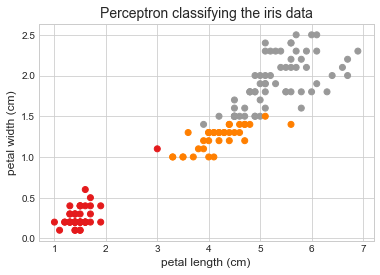

In [12]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load the iris data and only use petal length and width (cm.).
iris = load_iris()
X = iris.data[:, (2, 3)]
y = iris.target

# Train a perceptron.
per_clf = Perceptron()
per_clf.fit(X, y)

# Plot the prediction results.
plt.scatter(X[:, 0], X[:, 1], c=per_clf.predict(X), cmap='Set1')
plt.title('Perceptron classifying the iris data', fontsize=14)
plt.xlabel(iris.feature_names[2], fontsize=12)
plt.ylabel(iris.feature_names[3], fontsize=12)
plt.show()

## The multilayer perceptron (MLP) and backpropagation

An MLP has one *input layer* built of passthrough neurons, one or more *hidden layers* of TLUs, and one *ouput layer* of TLUs. 
The layers near the input are called *lower layers* whereas the layers near the output are *upper layers*.
When an ANN contains a deep stack of hidden layers, it is called a *deep neural network* (DNN).

*Backpropagation* makes training a MLP possible.
It is able to compute the gradient of the nwtwork's error with regard to every single model parameter.
Therefore, the connection weights and bias terms can be tweaked optimally to reduce error.
Once the gradient is found, normal gradient descent can be followed.
Below is the most basic interpretation of the algorithm:

1. A mini-batch is fed into the input layers.
2. The data progresses through the layers and the results of each layer are remembered. This is the *forward pass*.
3. A final output is calculated and a loss function is used to determine the error.
4. The chain rule is used to measure how much each output connected contributed to the error.
5. The error is *backpropagated* using the chain rule to measure how much of the error came from each connection in the network.
6. The error gradient is used to compute the optimal adjustments for each connection weight.

In order to compute the derivative of each neuron, the step function had to be replaced.
Currently, it is common to use the logistic equation, hyperbolic tangent function, or rectified linear unit (ReLU):

$$
\begin{aligned}
\text{logistic: }& \quad \sigma(z) = 1 / (1 + e^{-z}) \\
\text{hyperbolic tangent: }& \quad \tanh(z) = 2 \sigma(2z) - 1 \\
\text{ReLU: }& \quad \text{ReLU}(z) = \max(0, z) \\
\end{aligned}
$$

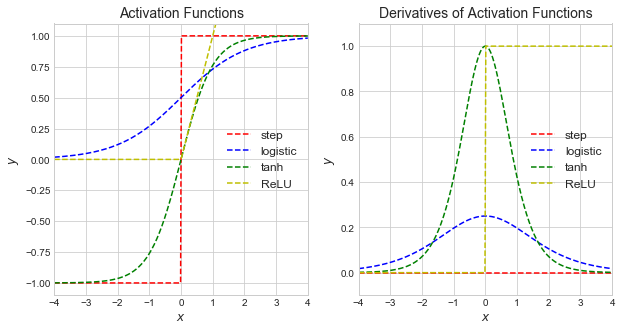

In [13]:
# Input points
x = np.linspace(-4, 4, 300)

# Neruon activation functions.

def step_fxn(x):
    """Step function for neuron activation function."""
    return [-1 if i < 0 else 1 for i in x]


def step_fxn_d(x):
    """Derivative of the step function."""
    return np.zeros(len(x))


def logistic_fxn(x):
    """Logisitc (sigmoid) function for neuron activation function."""
    return 1 / (1 + np.exp(-x))


def logistic_fxn_d(x):
    """The derivative of the logistic function."""
    return logistic_fxn(x) * (1 - logistic_fxn(x))


def hyperbolic_tan(x):
    """Hyperbolic tangent function for neuron activation function."""
    return 2 * logistic_fxn(2 * np.array(x)) - 1


def hyperbolic_tan_d(x):
    """The derivative of the hyperbolic tangent function."""
    return 1 - (np.tanh(x) ** 2)


def relu_fxn(x):
    """The ReLU for a neuron activation function."""
    return [max(0, i) for i in x]


def relu_fxn_d(x):
    """The derivative of the ReLU"""
    return [0 if i < 0 else 1 for i in x]


# Styles of line.
line_styles = {
    'step': 'r--',
    'logistic': 'b--',
    'tanh': 'g--',
    'relu': 'y--'
}

# Plotting each activation function.
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, step_fxn(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -1.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Activation Functions', fontsize=14)

# Plotting the derivatives of the activation function.
plt.subplot(1, 2, 2)
plt.plot(x, step_fxn_d(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn_d(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan_d(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn_d(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -0.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Derivatives of Activation Functions', fontsize=14)

plt.show()

### Regression MLP

For a regression MLP, there must be one output neuron per output variable.
The neuron's activation function must be chosen depending on any constraints on the output (e.g. always positive, between 0 and 1) and no activation function can be used to leave the output value unconstrained.
The loss function most  commonly used in the MSE, though the mean absolute error (MAE) or Huber loss (a mixture of MSE and MAE) can be used if the training data has a lot of outliers.

### Classification MLP

If the decision is a binary classification, then only one neuron is required with a logistic activation function.
If there are multiple decisions, but each is binary, then there must be a neuron per decision, each with a logistic activation function.
If there is a single decision, but multiple possibilities (i.e. the image of 1 of 10 digits), then there must be an output neuron for each option with a *softmax function* across the whole output layer.
The softmax function ensures that each neuron is between 0 and 1 (inclusive) and that they sum to 1.
The loss function is usually the cross-entropy loss function.

---

>**Before moving on to using Keras to build ANNs, I followed the advice of the author and skipped to Exercise 1 for the chapter which was to experiment in the [TensorFlow Playground](https://playground.tensorflow.org/).**

---

## Implementing MLPs with Keras



In [14]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.0.0'

In [15]:
keras.__version__

'2.2.4-tf'

### Building an image classifier using the sequential API

For the first example, we will build an image classifier of the MNIST Fashion data set.
It contains 70,000 28x28 grayscale images of clothing of 10 classes.

Keras provides some functions for accessing commonly used data.

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Each image is a 28x28 array.

In [17]:
X_train_full.shape

(60000, 28, 28)

Each data point is an integer between 0 and 255.

In [18]:
X_train_full.dtype

dtype('uint8')

We need to make a validation set from the training data and scale the data to between 0 and 1.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin


# Split the training data into training and validation.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      test_size=5000,
                                                      random_state=0)


class FashionImageFlatten(BaseEstimator, TransformerMixin):
    """Flatten the 28x28 MNIST Fashion image."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(len(X), 28*28)


class FashionImageReshape(BaseEstimator, TransformerMixin):
    """Reshape the 28x28 MNIST Fashion image."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(len(X), 28, 28)


# A pipeline for pre-processing the MNIST Fashion data.
fashion_preprocesser = Pipeline([
    ('flattener', FashionImageFlatten()),
    ('minmax_scaler', MinMaxScaler()),
    ('reshaper', FashionImageReshape())
])
fashion_preprocesser.fit(X_train)

X_train = fashion_preprocesser.transform(X_train)
X_valid = fashion_preprocesser.transform(X_valid)

The names of the classes was not provided, so I had to enter them manually.
I found the known values in the [Keras documentation](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles).

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

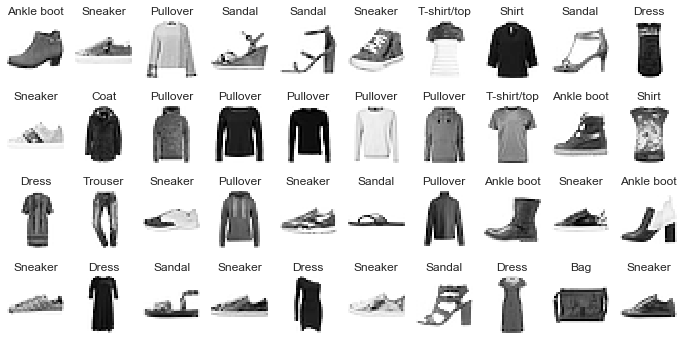

In [21]:
fig = plt.figure(figsize=(12, 6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i, :, :])
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.show()

The sequential API is used below to create the first neural network with two hidden layers.

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu', name='dense_1'))
model.add(keras.layers.Dense(100, activation='relu', name='dense_2'))
model.add(keras.layers.Dense(10, activation='softmax', name='dense_3'))

Here is an explanation of each line:

1. A sequential model is initialized. It is just a single stack of layers connected sequentially.
2. The first layer is the input nodes that just flattens the 28x28 image into a single array. Since it is the first layer, the shape of the input must be explicitly stated.
3. The first hidden layer is a dense network of 300 neurons each with a ReLU activation function.
4. The second hidden layer is a dense network of 100 neurons each with a ReLU activation function.
5. The output layer is a dense network of 10 neurons using a softmax activation function.

Alternatively, the model could have been declared directly when initializing the Sequential model by passing a list of the layers.
The model can be inspected with the `summary()` method.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The list of layers can be accessed and specifically indexed by name.

In [24]:
model.layers

In [25]:
model.get_layer('dense_1')

In [26]:
weights, biases = model.get_layer('dense_1').get_weights()

In [27]:
weights

array([[ 0.01909669, -0.03947309, -0.03040729, ..., -0.03438038,
         0.04921912,  0.00550243],
       [-0.03329127, -0.01047307, -0.07190025, ..., -0.05564579,
        -0.04258295, -0.05159908],
       [ 0.02722082,  0.03788579,  0.0499421 , ..., -0.05883027,
         0.03593911,  0.07339516],
       ...,
       [ 0.02745932,  0.01938465, -0.05722888, ...,  0.00050315,
        -0.01725952, -0.0181507 ],
       [ 0.05467865,  0.06947832,  0.05840707, ...,  0.04485394,
        -0.00939389,  0.06902052],
       [-0.06370141,  0.02759115,  0.0312682 , ...,  0.02090842,
         0.04941054,  0.03282518]], dtype=float32)

In [28]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Once the model's structure is created, it must be compiled.
This is when the loss function, optimizer, and any other metrics to be calculated during training and evaluation are added to the model.
There are additional parameters that we will learn about and opt to set in the future for increased performance.

In [29]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Now the model is ready to be trained using the `fit()` method.

In [30]:
history = model.fit(X_train, y_train, 
                    epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 9s 170us/sample - loss: 0.7055 - accuracy: 0.7665 - val_loss: 0.5268 - val_accuracy: 0.8188
Epoch 2/30
55000/55000 [==============================] - 8s 145us/sample - loss: 0.4885 - accuracy: 0.8307 - val_loss: 0.4418 - val_accuracy: 0.8524
Epoch 3/30
55000/55000 [==============================] - 8s 148us/sample - loss: 0.4439 - accuracy: 0.8460 - val_loss: 0.4289 - val_accuracy: 0.8510
Epoch 4/30
55000/55000 [==============================] - 8s 145us/sample - loss: 0.4146 - accuracy: 0.8558 - val_loss: 0.3939 - val_accuracy: 0.8644
Epoch 5/30
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3946 - accuracy: 0.8628 - val_loss: 0.3874 - val_accuracy: 0.8658
Epoch 6/30
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3775 - accuracy: 0.8677 - val_loss: 0.3698 - val_accuracy: 0.8696
Epoch 7/30
55000/55000 [===========================

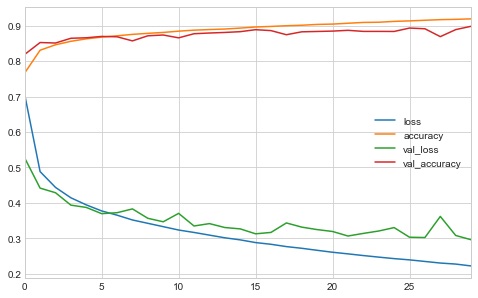

In [31]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

After tuning the hyperparamters (discussed later) and once we are satisfied with the models performance on the training data, we can evaluate its accuracy on the test data.

In [32]:
X_test_processed = fashion_preprocesser.transform(X_test)
model.evaluate(X_test_processed, y_test, verbose=0)

[0.32204199167490005, 0.8867]

We can also use the model to make predictions.
Using the `predict()` method, we get a probability per class.

In [33]:
X_new = fashion_preprocesser.transform(X_test[:3])
np.round(model.predict(X_new), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

The `predict_class()` method returns the class with the highest probability.

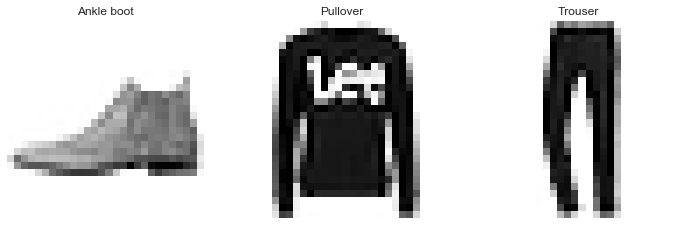

In [34]:
y_pred = model.predict_classes(X_new)

fig = plt.figure(figsize=(12, 6))
for i in range(len(X_new)):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_new[i, :, :])
    plt.title(class_names[y_pred[i]])
    plt.axis('off')

plt.show()

### Building a regression MLP using the sequential API

We will build a regression ANN to predict housing prices in CA.

In [35]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target, 
                                                              random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 150us/sample - loss: 0.7240 - val_loss: 0.5115
Epoch 2/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.4576 - val_loss: 0.4544
Epoch 3/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.4151 - val_loss: 0.4270
Epoch 4/20
11610/11610 [==============================] - 1s 88us/sample - loss: 0.3956 - val_loss: 0.4151
Epoch 5/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3836 - val_loss: 0.4002
Epoch 6/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3748 - val_loss: 0.4114
Epoch 7/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3694 - val_loss: 0.3898
Epoch 8/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3620 - val_loss: 0.3912
Epoch 9/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3568 - val_

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,471
Trainable params: 3,471
Non-trainable params: 0
_________________________________________________________________


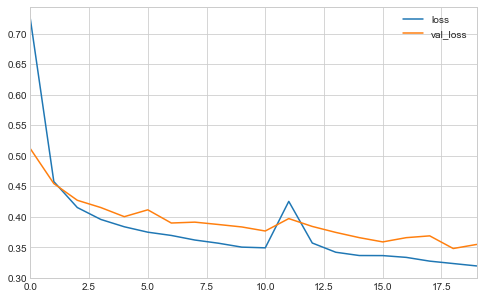

In [38]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [39]:
model.evaluate(X_test, y_test, verbose=0)

0.337194950913274

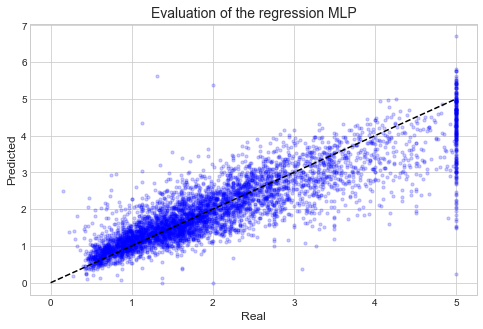

In [40]:
y_pred = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Evaluation of the regression MLP', fontsize=14)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

### Building complex models using the functional API

As an example of a more complex ANN topology, we will build a *Wide & Deep* neural network.
This is where some or all of the input layers connect directly to the output layer.
This allows the ANN to learn both simple and deep rules.
This architecture is built below using Keras's *functional API*.

In [41]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1, activation='relu')(concat)
model = keras.Model(inputs=[input_], outputs=[output])

Here is a line-by-line explanation:

1. First, an `Input` object is created with the shape and data type specified.
2. A dense layer with 30 neurons was created and connected to the input layer by passing it as input to a function.
3. A dense layer with 30 neurons was created and connected to the first hidden layer.
4. A `Concatenate` layer concatenated the input and second hidden layer.
5. An output layer was made and given the concatenate layer.
6. Finally, a Keras `Model` was created and given the input and output layers.

This strings together the layers to make a network.
A layer is connected to another by passing one as the input to a function call of the other.

Next, everything is the same as before.

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 170us/sample - loss: 1.0967 - val_loss: 0.6579
Epoch 2/20
11610/11610 [==============================] - 1s 111us/sample - loss: 0.5468 - val_loss: 0.5027
Epoch 3/20
11610/11610 [==============================] - 1s 111us/sample - loss: 0.5267 - val_loss: 0.4958
Epoch 4/20
11610/11610 [==============================] - 1s 111us/sample - loss: 0.4359 - val_loss: 0.4386
Epoch 5/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.3999 - val_loss: 0.4272
Epoch 6/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.3880 - val_loss: 0.4071
Epoch 7/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.3795 - val_loss: 0.4873
Epoch 8/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.3769 - val_loss: 0.4008
Epoch 9/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.3692 

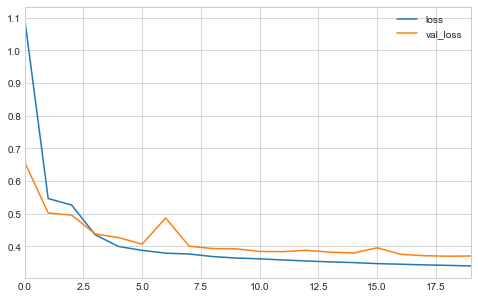

In [42]:
model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [43]:
model.evaluate(X_test, y_test, verbose=0)

0.35631471438001294

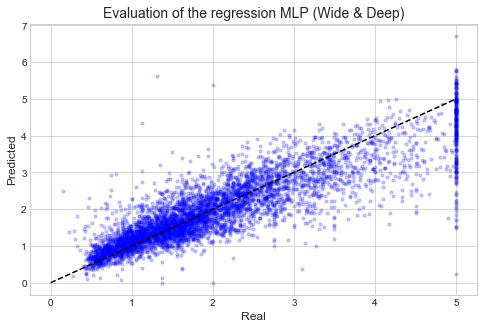

In [44]:
y_pred_new = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Evaluation of the regression MLP (Wide & Deep)', fontsize=14)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

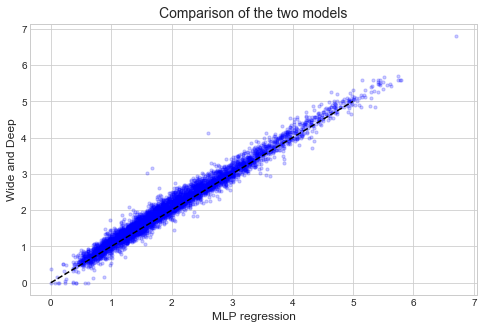

In [45]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_pred_new, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Comparison of the two models', fontsize=14)
plt.xlabel('MLP regression', fontsize=12)
plt.ylabel('Wide and Deep', fontsize=12)
plt.show()

It is also possible to have multiple inputs.
This can be useful if you only want some inputs to go through the hidden layers.
Below is an example where features 0 through 4 go through the wide path and 2 through 7 go through the hidden layers.

In [46]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          3100        dense_6[0][0]                    
____________________________________________________________________________________________

Compiling the model is the same as before.

In [47]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

To fit the model, we must pass two matrices, one per input.
Alternatively, a dictionary with keys of the input layer names and values of the input matrices can be passed.

In [48]:
def split_input_matrices(A):
    return A[:, :5], A[:, 2:]


history = model.fit(split_input_matrices(X_train),
                    y_train,
                    epochs=20,
                    validation_data=(split_input_matrices(X_valid), y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 168us/sample - loss: 1.9254 - val_loss: 0.9484
Epoch 2/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.8495 - val_loss: 0.7634
Epoch 3/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.7184 - val_loss: 0.6942
Epoch 4/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.6604 - val_loss: 0.6476
Epoch 5/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.6198 - val_loss: 0.6137
Epoch 6/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.5892 - val_loss: 0.5878
Epoch 7/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.5653 - val_loss: 0.5673
Epoch 8/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.5467 - val_loss: 0.5500
Epoch 9/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.5327 - val

In [49]:
model.evaluate(split_input_matrices(X_test), y_test, verbose=0)

0.48695583951103594

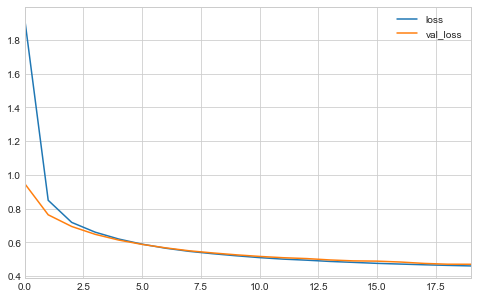

In [50]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

Adding outputs is just as easy in adding inputs.
The following code is the same structure as the *Wide & Deep* ANN except there is an additional output from the second hidden layer.

In [51]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          3100        dense_8[0][0]                    
____________________________________________________________________________________________

Each output requires a loss function and we can weight the loss scores by which we value more.
These are stated at the compile step.

In [52]:
model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

For fitting, each output also needs a set of labels.

In [53]:
history = model.fit(split_input_matrices(X_train), 
                    (y_train, y_train),
                    epochs=20,
                    validation_data=(
                        split_input_matrices(X_valid), 
                        (y_valid, y_valid)
                    ))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 246us/sample - loss: 1.0505 - output_loss: 0.9667 - aux_output_loss: 1.8011 - val_loss: 0.6166 - val_output_loss: 0.5594 - val_aux_output_loss: 1.1317
Epoch 2/20
11610/11610 [==============================] - 2s 140us/sample - loss: 0.6090 - output_loss: 0.5627 - aux_output_loss: 1.0263 - val_loss: 0.5358 - val_output_loss: 0.4978 - val_aux_output_loss: 0.8783
Epoch 3/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.4955 - output_loss: 0.4578 - aux_output_loss: 0.8345 - val_loss: 0.4886 - val_output_loss: 0.4574 - val_aux_output_loss: 0.7707
Epoch 4/20
11610/11610 [==============================] - 1s 126us/sample - loss: 0.4661 - output_loss: 0.4349 - aux_output_loss: 0.7469 - val_loss: 0.4844 - val_output_loss: 0.4605 - val_aux_output_loss: 0.6997
Epoch 5/20
11610/11610 [==============================] - 1s 126us/sample - loss: 0.4503 - output_loss:

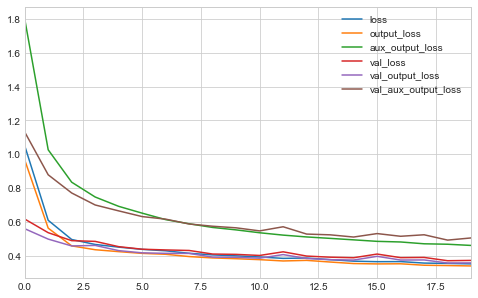

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [55]:
X_new = split_input_matrices(X_test)
y_new, y_new_aux = model.predict(X_new)

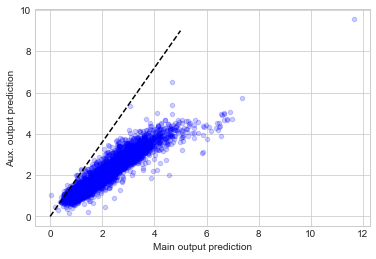

In [56]:
plt.scatter(y_new, y_new_aux, c='b', s=20, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 9, 10), 'k--')
plt.xlabel('Main output prediction')
plt.ylabel('Aux. output prediction')
plt.show()

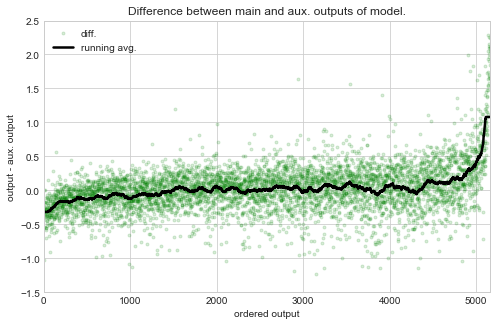

In [57]:
from sklearn.neighbors import KNeighborsRegressor
y_order = np.argsort(y_new.ravel())
y_diff = y_new[y_order] - y_new_aux[y_order]
x = np.arange(len(y_diff)).reshape(-1, 1)

knn = KNeighborsRegressor(n_neighbors=100)
y_knn = knn.fit(x, y_diff).predict(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y_diff, 'g.', alpha=0.15, label='diff.')
plt.plot(x, y_knn, 'k-', linewidth=2.5, label='running avg.')
plt.axis((0, np.max(x), -1.5, 2.5))
plt.xlabel('ordered output')
plt.ylabel('output - aux. output')
plt.title('Difference between main and aux. outputs of model.')
plt.legend(loc='best')
plt.show()

### Using the subclassing API to build dynamic models

The Sequential and Functional APIs are declariative and, thus, have a static model graph.
This has many advantages because TF can display and analyze the graph.
However, this means it has limited flebibility.

The Subclassing API adds limitless flexibility.
The main steps are to subclass the `Model` class, create the layers in the constructor, and use them to perform any computations in the `call()` method.
The `call()` method can do anything the programming likes, including using for-loops or logical branching.

Below is an implementation of the *Wide & Deep* model from above using the Subclassing API.

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 188us/sample - loss: 1.0742 - output_1_loss: 0.9809 - output_2_loss: 1.9124 - val_loss: 0.5835 - val_output_1_loss: 0.5319 - val_output_2_loss: 1.0490
Epoch 2/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.5414 - output_1_loss: 0.4912 - output_2_loss: 0.9942 - val_loss: 0.5239 - val_output_1_loss: 0.4776 - val_output_2_loss: 0.9414
Epoch 3/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.4949 - output_1_loss: 0.4534 - output_2_loss: 0.8679 - val_loss: 0.4820 - val_output_1_loss: 0.4463 - val_output_2_loss: 0.8033
Epoch 4/20
11610/11610 [==============================] - 1s 100us/sample - loss: 0.4795 - output_1_loss: 0.4470 - output_2_loss: 0.7711 - val_loss: 0.4765 - val_output_1_loss: 0.4509 - val_output_2_loss: 0.7075
Epoch 5/20
11610/11610 [==============================] - 1s 117us/sample - loss: 0.4503 - output_1_loss:

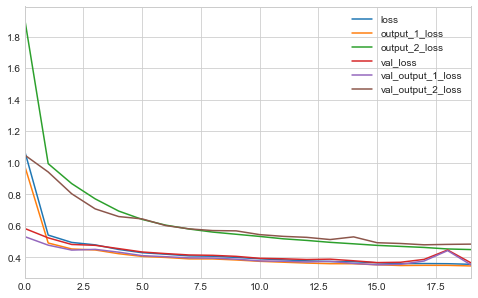

In [58]:
class WideAndDeep(keras.Model):
    """
    The 'Wide & Deep' ANN using the subclassing Keras API.
    """

    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)  # handles standard argumentas such as `name`
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aut_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aut_output(hidden2)
        return main_output, aux_output


# Create the model object, compile, and fit.
model = WideAndDeep()
model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

history = model.fit(split_input_matrices(X_train),
                    (y_train, y_train),
                    epochs=20,
                    validation_data=(
                        split_input_matrices(X_valid),
                        (y_valid, y_valid)
))

# Plot the progress of the training.
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In general, it is safer and easier to use the Sequential and Functional Keras APIs.

### Saving and Restoring a Model

Saving a model created using the Sequential or Functional APIs is simple and shown below.

In [59]:
# ** An example model built using the functional API ** #
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1, activation='relu')(concat)
model = keras.Model(inputs=[input_], outputs=[output])

model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

model.summary()

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 177us/sample - loss: 0.8410 - val_loss: 0.5378
Epoch 2/20
11610/11610 [==============================] - 1s 109us/sample - loss: 0.5082 - val_loss: 0.5506
Epoch 3/20
11610/11610 [==============================] - 1s 105us/sample - loss: 0.4695 - val_loss: 0.4615
Epoch 4/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.4172 - val_loss: 0.4949
Epoch 5/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.4006 - val_loss: 0.4349
Epoch 6/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3883 - val_loss: 0.3973
Epoch 7/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.3745 - val_loss: 0.3925
Epoch 8/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.3690 - val_loss: 0.3871
Epoch 9/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.358

In [60]:
import pathlib

# Save the model.
assets_path = pathlib.Path('assets/ch10')
model.save(assets_path.joinpath('my_keras_model.h5'))

Then, the model can be loaded using the `load()` method.

In [61]:
model = keras.models.load_model(assets_path.joinpath('my_keras_model.h5'))

The process is not very easy if the model was built with the Subclassing API.
The programmer would have to save and load the model parameters with `save_weights()` and `load_weights()` explcitly, and then recreate the model manually.

### Using Callbacks

The `fit()` method accepts a `callback` argument that is a list of `callback` objects that get called during each round (the point at which they get called can be specified, too).
They are useful for when a model may take a long time to train and you want to save intermediates such that they can be re-loaded if the computer crashes midway.
Another useful case is to set `save_bast_only=True` for a `ModelCheckpoint` callback object to that only the best model on the validation data is saved.
This can help prevent overfitting by essentially implementing early-stopping.

In [62]:
# Create the model.
model = keras.Model(inputs=[input_], outputs=[output])

# Compile the model.
model.compile(loss='mean_squared_error', optimizer='sgd')

# Add a checkpoint to save the model on each round of training.
# The model is only saved if it improves upon the previous on the
#   validation data set.
checkpoint_path = assets_path.joinpath('my_keras_model_chkpt.h5')
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path.as_posix(),
                                                save_best_only=True)

# Fit the model.
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 161us/sample - loss: 0.3252 - val_loss: 0.3546
Epoch 2/20
11610/11610 [==============================] - 1s 110us/sample - loss: 0.3211 - val_loss: 0.3474
Epoch 3/20
11610/11610 [==============================] - 1s 100us/sample - loss: 0.3187 - val_loss: 0.3470
Epoch 4/20
11610/11610 [==============================] - 1s 111us/sample - loss: 0.3161 - val_loss: 0.3574
Epoch 5/20
11610/11610 [==============================] - 2s 163us/sample - loss: 0.3129 - val_loss: 0.3438
Epoch 6/20
11610/11610 [==============================] - 2s 131us/sample - loss: 0.3113 - val_loss: 0.3433
Epoch 7/20
11610/11610 [==============================] - 2s 138us/sample - loss: 0.3100 - val_loss: 0.3403
Epoch 8/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.3087 - val_loss: 0.3375
Epoch 9/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.304

Alternatively, the `EarlyStopping` callback can be used.
A common implementation is to use both `ModelCheckpoint` and `EarlyStopping` together, the first to save intermediate models in case of a crash, the latter to prevent unnecessary time spent on training.
The number of epochs can also be increased because early-stopping will prevent overfitting and excessive training..

In [63]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


# Add a checkpoint to save the model on each round of training.
# The model is only saved if it improves upon the previous on the
#   validation data set.
checkpoint_path = assets_path.joinpath('my_keras_model_chkpt.h5')
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path.as_posix(),
                                                save_best_only=True)

# Implement easly stopping after no improvement for 5 epochs.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

history = model.fit(split_input_matrices(X_train),
                    (y_train, y_train),
                    epochs=100,
                    validation_data=(
                        split_input_matrices(X_valid),
                        (y_valid, y_valid)
                    ),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 226us/sample - loss: 0.8896 - output_loss: 0.7873 - aux_output_loss: 1.8080 - val_loss: 0.9425 - val_output_loss: 0.9372 - val_aux_output_loss: 0.9891
Epoch 2/100
11610/11610 [==============================] - 1s 119us/sample - loss: 0.5127 - output_loss: 0.4671 - aux_output_loss: 0.9238 - val_loss: 0.4873 - val_output_loss: 0.4512 - val_aux_output_loss: 0.8126
Epoch 3/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.4654 - output_loss: 0.4318 - aux_output_loss: 0.7680 - val_loss: 0.4618 - val_output_loss: 0.4323 - val_aux_output_loss: 0.7279
Epoch 4/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.4463 - output_loss: 0.4193 - aux_output_loss: 0.6892 - val_loss: 0.4491 - val_output_loss: 0.4244 - val_aux_output_loss: 0.6712
Epoch 5/100
11610/11610 [==============================] - 1s 121us/sample - loss: 0.4345 - output_

11610/11610 [==============================] - 1s 117us/sample - loss: 0.3272 - output_loss: 0.3174 - aux_output_loss: 0.4149 - val_loss: 0.3474 - val_output_loss: 0.3364 - val_aux_output_loss: 0.4460
Epoch 40/100
11610/11610 [==============================] - 1s 116us/sample - loss: 0.3307 - output_loss: 0.3215 - aux_output_loss: 0.4128 - val_loss: 0.3488 - val_output_loss: 0.3378 - val_aux_output_loss: 0.4481
Epoch 41/100
11610/11610 [==============================] - 1s 119us/sample - loss: 0.3254 - output_loss: 0.3159 - aux_output_loss: 0.4108 - val_loss: 0.3389 - val_output_loss: 0.3280 - val_aux_output_loss: 0.4366
Epoch 42/100
11610/11610 [==============================] - 1s 118us/sample - loss: 0.3243 - output_loss: 0.3151 - aux_output_loss: 0.4083 - val_loss: 0.3425 - val_output_loss: 0.3320 - val_aux_output_loss: 0.4375
Epoch 43/100
11610/11610 [==============================] - 1s 116us/sample - loss: 0.3230 - output_loss: 0.3139 - aux_output_loss: 0.4046 - val_loss: 0.3421

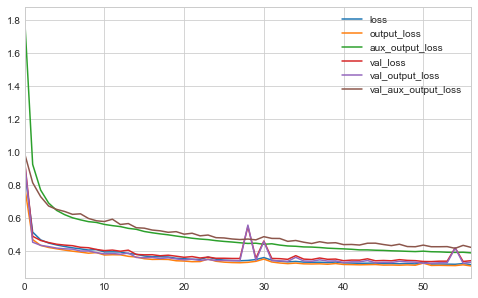

In [64]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

It is also possible to implement custom callbacks by subclassing `Callback` and defining methods with names such as `on_epoch_begin()`, `on_train_begin()`, and more.
Below is an example that logs the validation over training error on each epoch to detect overfitting.

In [65]:
class PrintValidationTrainingRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nval/train: {logs["val_loss"] / logs["loss"]}')

### Using Tensorboard for Visualization

Tensorboard is a powerful visualization tool for Tensorflow models.
To run it, we must save special binary log files called *event files* to a subdirectory in a root log folder.
It is best to save each record (called a *summary*) to s unique subdirectory so it can be inspected in the future.

Below is a function that creates a new subdirectory based on the date and time.

In [66]:
from pathlib import Path
root_logdir = Path('tf_logs')

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S')
    return root_logdir.joinpath(run_id).as_posix()

In [67]:
get_run_logdir()

'tf_logs/run_2020_01_02_09_14_53'

Below, I train and run two ANNs on the blobs artificial data set.

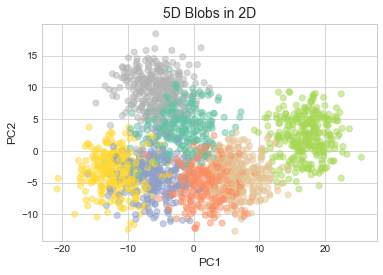

In [68]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

X_blob, y_blob = make_blobs(n_samples=2000,
                            n_features=5,
                            centers=7,
                            cluster_std=3,
                            random_state=0)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        shuffle=True,
                                                                        random_state=0)

pca = PCA(n_components=2)
blob_reduced = pca.fit_transform(X_blob)

plt.scatter(blob_reduced[:, 0], blob_reduced[:, 1],
            c=y_blob, cmap='Set2', alpha=0.5)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('5D Blobs in 2D', fontsize=14)
plt.show()

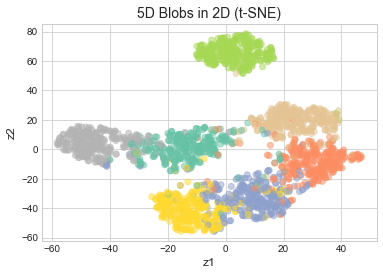

In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
blob_reduced = tsne.fit_transform(X_blob)

plt.scatter(blob_reduced[:, 0], blob_reduced[:, 1],
            c=y_blob, cmap='Set2', alpha=0.5)
plt.xlabel('z1', fontsize=12)
plt.ylabel('z2', fontsize=12)
plt.title('5D Blobs in 2D (t-SNE)', fontsize=14)
plt.show()

In [70]:
# Construct.
ann_1 = keras.models.Sequential([
    keras.layers.Input(shape=X_blob.shape[1]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile.
ann_1.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Callback for Tensorboard.
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Train.
history = ann_1.fit(X_blob_train, 
          y_blob_train, 
          epochs=30, 
          validation_split=0.2, 
          callbacks=[tensorboard_cb])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 873us/sample - loss: 1.3061 - accuracy: 0.5925 - val_loss: 0.6875 - val_accuracy: 0.7667
Epoch 2/30
1200/1200 [==============================] - 0s 177us/sample - loss: 0.5643 - accuracy: 0.8217 - val_loss: 0.4844 - val_accuracy: 0.8567
Epoch 3/30
1200/1200 [==============================] - 0s 192us/sample - loss: 0.4466 - accuracy: 0.8567 - val_loss: 0.4179 - val_accuracy: 0.8733
Epoch 4/30
1200/1200 [==============================] - 0s 170us/sample - loss: 0.3986 - accuracy: 0.8758 - val_loss: 0.3851 - val_accuracy: 0.8900
Epoch 5/30
1200/1200 [==============================] - 0s 203us/sample - loss: 0.3716 - accuracy: 0.8775 - val_loss: 0.3723 - val_accuracy: 0.8800
Epoch 6/30
1200/1200 [==============================] - 0s 289us/sample - loss: 0.3552 - accuracy: 0.8808 - val_loss: 0.3558 - val_accuracy: 0.8800
Epoch 7/30
1200/1200 [==============================] - 0s 254us/

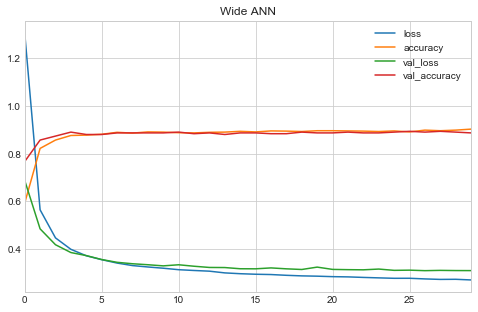

In [71]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Wide ANN')
plt.show()

In [72]:
# Construct.
ann_2 = keras.models.Sequential([
    keras.layers.Input(shape=X_blob.shape[1]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile.
ann_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Callback for Tensorboard.
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Train.
history = ann_2.fit(X_blob_train, 
          y_blob_train, 
          epochs=30, 
          validation_split=0.2, 
          callbacks=[tensorboard_cb])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 893us/sample - loss: 2.0109 - accuracy: 0.1733 - val_loss: 1.7095 - val_accuracy: 0.2433
Epoch 2/30
1200/1200 [==============================] - 0s 203us/sample - loss: 1.5423 - accuracy: 0.3992 - val_loss: 1.4448 - val_accuracy: 0.4833
Epoch 3/30
1200/1200 [==============================] - 0s 180us/sample - loss: 1.2906 - accuracy: 0.5058 - val_loss: 1.2221 - val_accuracy: 0.5100
Epoch 4/30
1200/1200 [==============================] - 0s 181us/sample - loss: 1.0909 - accuracy: 0.5683 - val_loss: 1.0581 - val_accuracy: 0.5533
Epoch 5/30
1200/1200 [==============================] - 0s 188us/sample - loss: 0.9372 - accuracy: 0.6542 - val_loss: 0.9213 - val_accuracy: 0.6667
Epoch 6/30
1200/1200 [==============================] - 0s 207us/sample - loss: 0.8025 - accuracy: 0.7425 - val_loss: 0.7897 - val_accuracy: 0.7067
Epoch 7/30
1200/1200 [==============================] - 0s 186us/

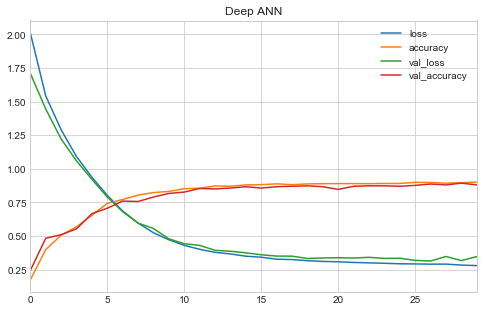

In [73]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Deep ANN')
plt.show()

Tensorboard can be started either from the CLI or through magic commands in a Jupyter Notebook.
The latter is used to activate Tesnorboard below.
For the CLI method, just use the second command without the leading `%`.

In [74]:
%load_ext tensorboard
%tensorboard --logdir=./tf_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10023), started 0:10:20 ago. (Use '!kill 10023' to kill it.)

## Fine-tuning neural network hyperparameters